<a href="https://colab.research.google.com/github/mcpikep/Student-ML-Exercise/blob/main/Bond_Classification_Student_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Bond Class Using Machine Learning: A pedagogical exercise to introduce ML in a chemistry context

The goal of this exercise is for you to go through the normal workflow of a data sciencist working with machine learning to predict bond classification of diatomic molecules (ionic, covalent, metallic, or metalloid) and predict the percent ionic character of the bond. You will need to import and process data. After which, you will evaluate several different classification (bond type) and regression models (% ionic character). Once, the best performing models are choosen, you will implement the alogrithm for these models. Then, you will evaluate performance and tune hyperparameters of the models you implement.

##Outline

0. Importing and Installing Python Packages
1. Data Processing
2. Classification
3. Regression

##Imports and Installs

First, you need to install and import necessary libraries and packages into your environment

The Lazy Predicts module is an package that utilizes the machine learning Sci-Kit Learn library to quickly evaluate several models at once to determine the best preforming ones.

We will also be using the sklearn library to prepare data sets, implement models, and evaluate them.

Other common Python packages that will used include matplotlib, seaborn, and plotly for data visualization. Also, Numpy will be used to handle numerical operations while Pandas wiil be used for data manipulation.

In [ ]:
# pip is a command-line tool to install and manage Python packages
!pip install lazypredict

In [ ]:
import io #Used for handling input/output from the computers OS
from google.colab import files #Used to upload files into Colab
import math #Package containing more advanced operations
import pandas as pd #Used for data manipulation
import numpy as np #Used for numerical operations
from collections import Counter #Used for counting elements in a list

#Data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Machine learning packages
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score

#Data

##Data Importing

Next, you need to import the data fromt the Excel file provided (taken from PubChem Periodic Table). Depending on the location of the file you wish to import, there are several ways to get the information in your Python environment.

The Pandas library is used for data handling and will convert Excel or CSV files into 'DataFrames'. DataFrames are a data structure similar to a this file types with individual elements (items) into rows and columns.


When typing in a code cell, the hashmark, #, blocks off everything on that line after it as a comment. This is a good way to give information about specific lines or sections of code, but it also is a way to block code you do not need to run.

Remove the # to select code that applies to the location of your file. Remember to put a # in front of any of the others you are not using.

In [ ]:
from google.colab import files
import pandas as pd
import io

In [ ]:
#FOR UPLOADING FROM YOUR COMPUTER
uploaded = files.upload()
df = pd.read_excel(io.BytesIO(uploaded['elements_EN.xlsx']))

#FOR UPLOADING FROM GOOGLE DRIVE
# from google.colab import drive
# drive.mount('/content/drive')

#FOR UPLOADING FROM ENVIRONMENT
# data = pd.read_excel("elements_EN.xlsx")

KeyError: 'elements_EN.xlsx'

This creates a dataframe called 'df' which contains the information from the excel file. Run the next cell to look over some of the information.

In [ ]:
df

,Atomic Number,Symbol,Electronegativity (Pauling Scale),GroupBlock
0,1,H,2.20,Nonmetal
1,2,He,NaN,Noble gas
2,3,Li,0.98,Alkali metal
3,4,Be,1.57,Alkaline earth metal
4,5,B,2.04,Metalloid
...,...,...,...,...
113,114,Fl,NaN,Post-transition metal
114,115,Mc,NaN,Post-transition metal
115,116,Lv,NaN,Post-transition metal
116,117,Ts,NaN,Halogen


Notice the unnamed column at the left end of the table. This is the index and in most cases in computer science, an index will begin with 0 and thus, if your data have n elements, it will have n-1 indices.

##Data Processing

###Looking at the Data

Pandas dataframes have a number of useful functions. One of the most important is the info function which will print basic information about the data such as index range, # of columns, and data types.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Atomic Number                      118 non-null    int64  
 1   Symbol                             118 non-null    object 
 2   Electronegativity (Pauling Scale)  95 non-null     float64
 3   GroupBlock                         118 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.8+ KB


Notice the 'Non-Null Count' column. This tells you how many elements are missing in each column by comparing to the index enties. The 'Electronegativity' column is missing some entries and you need to do something about this because they will either prevent the models from training properly or from running all together.

There are several methods for handling missing data and depending on the application in might be purdent to average the value of the column and use that as the missing value or perhaps convert all null entries to zero. For this exercise, you should simple remove any rows that are missing data. This can be done with the dropna function of the dataframe.

In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95 entries, 0 to 102
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Atomic Number                      95 non-null     int64  
 1   Symbol                             95 non-null     object 
 2   Electronegativity (Pauling Scale)  95 non-null     float64
 3   GroupBlock                         95 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ KB


So 95 elements remain with electronegativity values.

###Names, Differences, and Averages

Bond classification is based on the difference in electronegativity between the two consistent atoms and the average of the electronegativities.

So, you must create a list that contains these two values for each pair of diatomics.

In [ ]:
en_diff = []
for en in df["Electronegativity (Pauling Scale)"]:
  for en_1 in df["Electronegativity (Pauling Scale)"]:
      delta_en = abs(en - en_1)
      en_diff.append(delta_en)

print(en_diff)

[0.0, 1.2200000000000002, 0.6300000000000001, 0.16000000000000014, 0.34999999999999964, 0.8399999999999999, 1.2399999999999998, 1.7799999999999998, 1.27, 0.8900000000000001, 0.5900000000000001, 0.30000000000000027, 0.010000000000000231, 0.3799999999999999, 0.96, 1.3800000000000003, 1.2000000000000002, 0.8400000000000001, 0.6600000000000001, 0.5700000000000003, 0.5400000000000003, 0.6500000000000001, 0.3700000000000001, 0.3200000000000003, 0.29000000000000026, 0.30000000000000027, 0.5500000000000003, 0.3900000000000001, 0.1900000000000004, 0.020000000000000018, 0.34999999999999964, 0.7599999999999998, 0.7999999999999998, 1.3800000000000003, 1.2500000000000002, 0.9800000000000002, 0.8700000000000001, 0.6000000000000001, 0.040000000000000036, 0.30000000000000027, 0.0, 0.07999999999999963, 0.0, 0.27000000000000024, 0.5100000000000002, 0.42000000000000015, 0.2400000000000002, 0.15000000000000036, 0.10000000000000009, 0.45999999999999996, 0.3999999999999999, 1.4100000000000001, 1.31, 1.1, 1.

Now, calculate the average of the electronegativity of the two atoms.

In [ ]:
en_avg = []
for en in df["Electronegativity (Pauling Scale)"]:
  for en_1 in df["Electronegativity (Pauling Scale)"]:
    avg = (en + en_1)/2
    en_avg.append(avg)

print(en_avg)

[2.2, 1.59, 1.8850000000000002, 2.12, 2.375, 2.62, 2.8200000000000003, 3.09, 1.5650000000000002, 1.7550000000000001, 1.9050000000000002, 2.05, 2.1950000000000003, 2.39, 2.68, 1.51, 1.6, 1.7800000000000002, 1.87, 1.915, 1.9300000000000002, 1.875, 2.015, 2.04, 2.055, 2.05, 1.925, 2.005, 2.105, 2.1900000000000004, 2.375, 2.58, 2.6, 1.51, 1.5750000000000002, 1.71, 1.7650000000000001, 1.9000000000000001, 2.18, 2.05, 2.2, 2.24, 2.2, 2.065, 1.945, 1.9900000000000002, 2.08, 2.125, 2.1500000000000004, 2.43, 2.4000000000000004, 1.495, 1.5450000000000002, 1.6500000000000001, 1.6600000000000001, 1.665, 1.67, 1.685, 1.7000000000000002, 1.71, 1.715, 1.7200000000000002, 1.725, 1.735, 1.75, 1.85, 2.2800000000000002, 2.05, 2.2, 2.2, 2.24, 2.37, 2.1, 1.9100000000000001, 2.265, 2.1100000000000003, 2.1, 2.2, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.79, 1.7800000000000002, 1.7400000000000002, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.59, 0.98, 1.275, 1.51, 1.765, 2.01, 2.21

To help keep track of all the diatomics, you should combined each chemical symbol.

In [ ]:
diatomics = []
for element in df["Symbol"]:
    for element_1 in df["Symbol"]:
        molecule = element + element_1
        diatomics.append(molecule)

print(diatomics)

['HH', 'HLi', 'HBe', 'HB', 'HC', 'HN', 'HO', 'HF', 'HNa', 'HMg', 'HAl', 'HSi', 'HP', 'HS', 'HCl', 'HK', 'HCa', 'HSc', 'HTi', 'HV', 'HCr', 'HMn', 'HFe', 'HCo', 'HNi', 'HCu', 'HZn', 'HGa', 'HGe', 'HAs', 'HSe', 'HBr', 'HKr', 'HRb', 'HSr', 'HY', 'HZr', 'HNb', 'HMo', 'HTc', 'HRu', 'HRh', 'HPd', 'HAg', 'HCd', 'HIn', 'HSn', 'HSb', 'HTe', 'HI', 'HKe', 'HCs', 'HBa', 'HLa', 'HCe', 'HPr', 'HNd', 'HSm', 'HGd', 'HDy', 'HHo', 'HEr', 'HTm', 'HLu', 'HHf', 'HTa', 'HW', 'HRe', 'HOs', 'HIr', 'HPt', 'HAu', 'HHg', 'HTl', 'HPb', 'HBi', 'HPo', 'HAt', 'HFr', 'HRa', 'HAc', 'HTh', 'HPa', 'HU', 'HNp', 'HPu', 'HAm', 'HCm', 'HBk', 'HCf', 'HEs', 'HFm', 'HMd', 'HNo', 'HLr', 'LiH', 'LiLi', 'LiBe', 'LiB', 'LiC', 'LiN', 'LiO', 'LiF', 'LiNa', 'LiMg', 'LiAl', 'LiSi', 'LiP', 'LiS', 'LiCl', 'LiK', 'LiCa', 'LiSc', 'LiTi', 'LiV', 'LiCr', 'LiMn', 'LiFe', 'LiCo', 'LiNi', 'LiCu', 'LiZn', 'LiGa', 'LiGe', 'LiAs', 'LiSe', 'LiBr', 'LiKr', 'LiRb', 'LiSr', 'LiY', 'LiZr', 'LiNb', 'LiMo', 'LiTc', 'LiRu', 'LiRh', 'LiPd', 'LiAg', 'LiCd',

Now, a new dataframe with the infromation about the diatomics needs to be created. While there are a few ways to do this, one of the easiest is to first make a dictionary which will map the column name to the lists of information that you want to put in each column. Dictionaries are denotes with {} in Python.

In [ ]:
data_dict = {'Molecule': diatomics, 'Delta EN': en_diff, 'Average EN': en_avg}
data = pd.DataFrame(data_dict)
data

,Molecule,Delta EN,Average EN
0,HH,0.00,2.20
1,HLi,1.22,1.59
2,HBe,0.63,1.89
3,HB,0.16,2.12
4,HC,0.35,2.38
...,...,...,...
9020,LrEs,0.00,1.30
9021,LrFm,0.00,1.30
9022,LrMd,0.00,1.30
9023,LrNo,0.00,1.30


###Labels

All of the ML in this project is going to be 'supervised' learning. Supervised machine learning just means that all the training point also have the correct label. For example, if you wanted to classify dog and cat pictures, the pictures you train the model on would need to be labeled as cat or dog first.

In this exercise, it means that we need to classify the bonds before training the model. To produce the labels for the supervised learning models, we will look to a quantitative *van Arkel-Ketelaar triangle* (as called the bond triangle).

The different regions of the triangle are separated by lines, you can use the equations of the lines and > and < to segment the data.

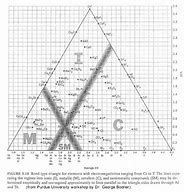

In [ ]:
bond_type = []
for d_en, av_en in zip(data['Delta EN'], data['Average EN']):

  if d_en >= 2 * av_en - 2.76 and d_en >= -2 * av_en + 4.4:
    bond = "Ionic"
    bond_type.append(bond)

  elif 2 * av_en - 2.76 >= d_en >= -2 * av_en + 4.4:
    bond = "Covalent"
    bond_type.append(bond)

  elif 2 * av_en - 2.76 > d_en and -2 * av_en + 4.4 > d_en:
    bond = "Metalloid"
    bond_type.append(bond)

  else:
    bond = "Metallic"
    bond_type.append(bond)

print(bond_type)

['Covalent', 'Ionic', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Ionic', 'Ionic', 'Covalent', 'Metalloid', 'Covalent', 'Covalent', 'Covalent', 'Ionic', 'Ionic', 'Ionic', 'Covalent', 'Covalent', 'Covalent', 'Metalloid', 'Covalent', 'Covalent', 'Covalent', 'Metalloid', 'Covalent', 'Metalloid', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Ionic', 'Ionic', 'Metallic', 'Ionic', 'Covalent', 'Covalent', 'Metalloid', 'Covalent', 'Covalent', 'Covalent', 'Metalloid', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Ionic', 'Ionic', 'Ionic', 'Ionic', 'Ionic', 'Metallic', 'Ionic', 'Ionic', 'Metallic', 'Ionic', 'Ionic', 'Ionic', 'Ionic', 'Metallic', 'Covalent', 'Covalent', 'Metalloid', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Covalent', 'Ionic', 'Ionic', 'Ionic', 'Metallic', 'Covalent', 'Ionic', 'Ionic', 'Ionic', 'Metallic', 'Metallic', 'Metallic', 'M

You need to add this list of labels as a column to the dataframe

In [ ]:
data["Bond Type"] = bond_type
data

,Molecule,Delta EN,Average EN,Bond Type
0,HH,0.00,2.20,Covalent
1,HLi,1.22,1.59,Ionic
2,HBe,0.63,1.89,Covalent
3,HB,0.16,2.12,Covalent
4,HC,0.35,2.38,Covalent
...,...,...,...,...
9020,LrEs,0.00,1.30,Metallic
9021,LrFm,0.00,1.30,Metallic
9022,LrMd,0.00,1.30,Metallic
9023,LrNo,0.00,1.30,Metallic


The Bond Types are in a datatype called a 'string' that stores inputs as word. We will need numerical values for the models we are using today. So let's make numeric labels for each bond type.

In [ ]:
data['Labels'] = data['Bond Type'].copy() # creates a copy as a new column
data['Labels'] = pd.Categorical(data['Labels']) # creates discrete categorical data for each type
data['Labels'] = data['Labels'].cat.codes # converts categorical data into numerical representations

data

,Molecule,Delta EN,Average EN,Bond Type,Labels
0,HH,0.00,2.20,Covalent,0
1,HLi,1.22,1.59,Ionic,1
2,HBe,0.63,1.89,Covalent,0
3,HB,0.16,2.12,Covalent,0
4,HC,0.35,2.38,Covalent,0
...,...,...,...,...,...
9020,LrEs,0.00,1.30,Metallic,2
9021,LrFm,0.00,1.30,Metallic,2
9022,LrMd,0.00,1.30,Metallic,2
9023,LrNo,0.00,1.30,Metallic,2


Moving forward, the covalent bond class is represented by 0, ionic is 1, metallic is 2, and metalloid is 3.

##Visualizing the Data

To check the work so far, you could look through every row of the dataframe to make sure all the values make sense, but that would be time consuming. It would be easier to visualize that data in a plot and compare it to the bond trinagle.

You should plot the data as a scatter plot of Delta EN vs Average EN

In [ ]:
fig = px.scatter(data_frame=data, x=data["Average EN"], y=data['Delta EN'], color=data['Bond Type'],
                 title='Bond Classifications', hover_name=data['Molecule'])

fig.update_traces(marker=dict(size=12, opacity=0.8), selector=dict(mode='markers+text'))

fig.show()

This is good the labels in the bonding triangle match the regions of the van Arkel-Ketelaar triangle

#Classification

Now that we have labels for the data, a supervised learning classifier can be choosen to test the predictive power of ML.

##Training and Evaluating Classification Models

Now that the data is collected and the labels have been generated, the classification models can be trained and tested to see which is preforming the best. The LazyPredict module will quickly evaluate several different kinds of classification algorithms. These are some of the most basic ML algorithms, and though we do not have time to go in depth on all the algorithms, we will showcase one of the top performers.

Before we can train any models, the data needs to be split into different sets: a larger one for training the models, and a smaller one for testing the models predicts.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = data['Labels']
features = ['Delta EN', 'Average EN']
X = data[features]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

We can use lazypredict to test several different types of alogrithms at once and evaluate which one preforms the best.

In [ ]:
lazy_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = lazy_clf.fit(train_X, val_X, train_y, val_y)

 93%|█████████▎| 27/29 [00:06<00:00,  5.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 6768, number of used features: 2
[LightGBM] [Info] Start training from score -1.592298
[LightGBM] [Info] Start training from score -1.717462
[LightGBM] [Info] Start training from score -0.716467
[LightGBM] [Info] Start training from score -2.051468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:07<00:00,  3.76it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

To better visualize the results of the LazyClassifier, put them into a dataframe

In [ ]:
clf_results = pd.DataFrame(models)
clf_results

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,1.00,1.00,None,1.00,0.43
BaggingClassifier,1.00,1.00,None,1.00,0.08
ExtraTreesClassifier,1.00,1.00,None,1.00,0.32
ExtraTreeClassifier,1.00,1.00,None,1.00,0.01
LGBMClassifier,1.00,1.00,None,1.00,0.42
DecisionTreeClassifier,1.00,1.00,None,1.00,0.02
XGBClassifier,1.00,1.00,None,1.00,0.33
KNeighborsClassifier,0.99,0.99,None,0.99,0.13
SVC,0.95,0.94,None,0.95,0.30


LazyClassifier provides 5 different metrics to evaluate each of the 25 classification algorithms.

**Accuracy** is the ratio of all correctly predicted labels (true positives) to the total number of test points.

**Balance Accuracy** is the average of the Recall scores for each class. **Recall** or sensitivity is the ratio of true positives of the class to number of elements in the class.

**ROC AUC** is the area under the receiver operating characteristic curve. It is a metric that only applies to binary classification and will not give results for you multiclass exercise.

**F1 Score** is the harmonic mean (reciprocal of the arithmetic mean of the reciprocals of the elements in the given set) of recall and **precision**. **Precision** is the ratio of true positives to true positives and false positives of a class to all the elements predicted to be in the class. It represents the accuracy of positive predictions.

**Time Taken** is the amount of time in seconds it took to train and test each model. It is a useful stand-in for the amount of computational power each model requires.

By default, 25% of the data will be set aside as the testing set, but a specific value can be set by including either train_size= or test_size= and provide a value between 0 and 1. You can play around will the split size, however the relatively small dataset will supress the effects of split size which are more pronounced and import with larger datasets.

##Decision Tree Classifier Algorithm

The decision tree was one of the best preformer with high accuracy and low time. Let's make one for ourselves.

###Theory

Decision trees split data into classes by input features into binary questions (Yes/No, >, <, =, etc) called the 'feature split'. To start all data points are put into the 'Root' group. Based on the answer to the question the data is split into either left of rigth 'nodes'. Each node creates a new 'branch' in the tree based on different questions. When a node has only one class inside of it, the algorithm stops and that node is called a 'leaf'. Leaves can also be created in other ways such as setting a max depth to the tree. In these cases the most common class in the leaf is assigned to it.

**Lose Function**

At the heart of any ML algorithm is the loss (cost) function. This is the error associated with making a prediction that is minimized through training. Several kinds of loss functions exist, each with its own advantages and disadvantages and particular algorithms with which they work best.

For decision trees, the goal of the loss function should be to determine how good each split is, that is to say how "pure" or homogeneous is each subset that the split produces. There are several ways to do this, but *Gini Index* and *Entropy* are the most common functinos used.

A *Gini Index* or *Gini Impurity* is a measure of the probability that a new, random data point would be misclassified. A Gini index of 1 would mean that the split misclassified all the data points and a index of 0 means the split was perfectly pure.

The *Entropy* or *Shannon Entropy* is a measure of the disorder of the data after the split. An entropy of 0 means all elements in that subset belong to the same class and an entropy of 1 means the elements in the subset are evenly split between classes.

**EQUATIONS**

**Gini Index**
$$Gini = 1 - Σpⱼ^2$$  

**Entropy**
$$E = -\Sigma p(X) \cdotp log_2 (p(X)) $$

$$p(X) = \frac{\#x}{n}$$

**Information Gain**
$$IG = E(parent) - [Weighted Average] \cdotp E(childern)$$

Here is how to create these metrics using Python functions. In Python, you can create custom functions by using def <function name> (<function inputs>) then list the operation you want the function to do are written indented underneath. If you want the function to give a value at the end, you need to include the return line at the end.

In [ ]:
def Gini(y):
  hist = np.bincount(y)
  ps = hist / len(y)
  return 1 - np.sum(ps**2)

In [ ]:
def entropy(y):
    hist = np.bincount(y)  # numpy bin count tabulates all instances of each label (class) in y
    ps = hist / len(y)  # probability of each class (instances of class / total number of elements)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

def ig(parent, children):
    return entropy(parent) - entropy(children)

###Node Class

Next you need to create a node class. A class creates a custom object which can be used repeatedly and has specified attributes. For the node class, you need to have the feat_idx, threshold, left, right, and value attributes and a function that determines if the node is a leaf or not.

All Python classes start with an initialization function which simply constructs the object with stated attributes. You must include a self attribute which allows you to actually call the object.

In [ ]:
class Node:
    def __init__(self, feat_idx=None, threshold=None, left=None, right=None, *, value=None):
        self.feat_idx = feat_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        # determine if the node is terminal or not

        return self.value is not None  # if there is a value for the node function returns 'True'


###Tree Class

Now, you need to build the tree class. For the initialization function, you need to include **min_sample_split=2**, **max_depth=100**, and **n_feats=None** attributes along with self. These set the minimum number of samples required to further split the tree, set the maximum number of layers to the tree, and the number of features used in the splitting process, respectively.


Within the tree class, you need eight functions other than the **\_\_init__** fucntion:


  a.	The **fit** function which will take the train_X and train_y as inputs and will set the number of functions as the number of columns in train_X. It will also initialize the next function which grows the tree.

  b.	The **_grow_tree** function takes the same X and y as the fit and begins to count the number of layers (depth).

  c.	The **_most_common_label** function will determine the corresponding label for a leaf node.

  d.	The **_best_criteria** function will determine the best feature split at each branch.

  e.	The **_information_gain** function calculates the difference between the parent and branch entropy.

  f.	The**_split** function will create the split in the tree path.

  g.	The **predict function** is a callable function which takes in a validation set and makes predictions once the tree is constructed and trained.

  h.	The **_traverse_tree** function moves each training or validation element through the tree path.



Notice that there are two different predict functions, one with and underscore and one without. By convention, underscores before the name of a function denote them as internal functions to the class and are not called outside of it. The other function is callable and is used outside of the class.

In [ ]:
class DecisionTree:

    # the inputs for the decision tree are the stopping criteria
    def __init__(self, min_sample_split=2, max_depth=100, n_feats=None, ):
        # min_sample_split is the smallest amount of samples required to further split the tree
        self.min_sample_split = min_sample_split
        # max_depth is the most amount of layers of nodes the tree can have
        self.max_depth = max_depth
        # n_feat is the number of features
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        # grow tree
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Checking Stopping Criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_sample_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedy search
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(best_feat, best_thresh, left, right)

    def _most_common_label(self, y):
        counter = Counter(y)  # Counter is similar to np.bincount but has added functionality
        most_common = counter.most_common(1)[0][0]  # most_common(1) will return only the 1st most common class
        # returns a list of tuple, the 1st [0] returns the 1st tuple the 2nd [0] returns the value

        return most_common

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent entropy
        parent_entropy = entropy(y)
        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        # weighted avg child entropy
        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        e_left, e_right = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        # calculate IG
        ig = parent_entropy - child_entropy

        return ig

    def _split(self, X_column, split_thresh):
        # np.argwhere finds the indices of array elements that are <= or > threshold
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def predict(self, X):
        # traverse tree
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feat_idx] <= node.threshold:
            return self._traverse_tree(x, node.left)

        return self._traverse_tree(x, node.right)

##Running the Algorithm

In [ ]:
y = data['Labels']
y = y.to_numpy()
features = ['Average EN', 'Delta EN']
X = data[features]
X = X.to_numpy()
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

In [ ]:
tree = DecisionTree(max_depth=8)
tree.fit(train_X, train_y)  # Training the model with the train subsets
predictions = tree.predict(val_X) # Using the validation inputs to test

# Evaluation
report = classification_report(val_y, predictions)
print(report)

confusion_df = pd.DataFrame(confusion_matrix(val_y, predictions))
confusion_df = confusion_df.rename(index={0: 'Actual Covalent',
                                          1: 'Actual Ionic',
                                          2: 'Actual Metallic',
                                          3: 'Actual Metalloid'})

confusion_df.columns = ['Predicted Covalent',
                        'Predicted Ionc',
                        'Predicted Metallic',
                        'Predicted Metalloid']
confusion_df

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       477
           1       0.99      0.99      0.99       375
           2       1.00      1.00      1.00      1092
           3       1.00      0.93      0.96       313

    accuracy                           0.99      2257
   macro avg       0.99      0.98      0.98      2257
weighted avg       0.99      0.99      0.99      2257



,Predicted Covalent,Predicted Ionc,Predicted Metallic,Predicted Metalloid
Actual Covalent,477,0,0,0
Actual Ionic,2,373,0,0
Actual Metallic,0,2,1090,0
Actual Metalloid,20,0,2,291


Let's plot are results like we have been.

In [ ]:
results = {'Average EN': val_X[:, 0], 'Delta EN': val_X[:, 1],
           'Predictions': predictions}

results_df = pd.DataFrame(results)
results_df['Predictions'] = results_df['Predictions'].replace(
                                          {0: 'Predicted Covalent',
                                           1: 'Predicted Ionic',
                                           2: 'Predicted Metallic',
                                           3: 'Predicted Metalloid'})

fig = px.scatter(data_frame=results_df, x=results_df['Average EN'],
                 y=results_df['Delta EN'], color=results_df['Predictions'],
                 title='Predicted Bond Classifications')

fig.update_traces(marker=dict(size=12, opacity=0.8),
                  selector=dict(mode='markers+text'))

fig.show()

##Comparison to skearn Decision Tree

That was a bit of work to build that algorithm from strach. Luckily, the sklearn library provideds open-source access to previously built model that can be imported directly into your environmnet.

Let's see how this is done using the sklearn DecisionTreeClassifier model.

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=.66, random_state=0)

In [ ]:
bonding_tree = DecisionTreeClassifier()
bonding_tree.fit(train_X, train_y)
tree_predictions = bonding_tree.predict(val_X)

report = classification_report(val_y, tree_predictions)
print(report)

confusion_df = pd.DataFrame(confusion_matrix(val_y, tree_predictions))
confusion_df = confusion_df.rename(index={0: 'Actual Covalent', 1: 'Actual Ionic', 2: 'Actual Metallic', 3: 'Actual Metalloid'})
confusion_df.columns = ['Predicted Covalent', 'Predicted Ionc', 'Predicted Metallic', 'Predicted Metalloid']
confusion_df

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       652
           1       1.00      1.00      1.00       516
           2       1.00      1.00      1.00      1494
           3       1.00      0.99      1.00       407

    accuracy                           1.00      3069
   macro avg       1.00      1.00      1.00      3069
weighted avg       1.00      1.00      1.00      3069



,Predicted Covalent,Predicted Ionc,Predicted Metallic,Predicted Metalloid
Actual Covalent,652,0,0,0
Actual Ionic,0,516,0,0
Actual Metallic,0,2,1492,0
Actual Metalloid,2,0,2,403


#Regression

Classification is not the only problem ML model are good at solving. Let's look at a task that tries to predict a numerical value for a given input.

*Regression* is the name given to model that tries to predict numerical values as opposed to discrete class labels. Some of the algorithms that were used for classification problems can be altered to make regression predictions.

First, we need some numerical labels to use in the training and testing process.

##Labels

For an example of regression modeling, let's try to predict the percent ionic character of the bonds.

Pauling propused a simple equaitons for ionic character based off of the difference in electronegativity.

$$ Ionic \% = (1- e^{(-\frac{ΔΧ}{2})^2}) · 100 $$

In [ ]:
ionic_character = []
for value in en_diff:

  # Pauling's Equations
  percent = (1 - math.exp(-.25*(value**2))) * 100
  ionic_character.append(percent)

print(ionic_character)

[0.0, 31.071468945337376, 9.446106116086394, 0.6379563620851014, 3.0160805409297664, 16.171739677576646, 31.914097090807513, 54.71072787601052, 33.183825398340616, 17.965065585213402, 8.334582100777933, 2.224876280666366, 0.0024999687502580414, 3.545616572318455, 20.57841473834533, 37.87986409945493, 30.232367392896897, 16.171739677576657, 10.31799049762132, 7.801377879468985, 7.030620524304565, 10.02380044323461, 3.3645949486530435, 2.5275098398206075, 2.080551559865129, 2.224876280666366, 7.2836172188246895, 3.731112663147751, 0.8984396926888127, 0.009999500016666385, 3.0160805409297664, 13.445853777823391, 14.785621103378855, 37.87986409945493, 32.336615383827116, 21.345079778654508, 17.239972431749816, 8.60688147287718, 0.03999200106655776, 2.224876280666366, 0.0, 0.15987206823936395, 0.0, 1.8059929014893283, 6.295596301634987, 4.314173313809033, 1.4296815877557045, 0.5609209308919172, 0.24968776025399153, 5.15251447743954, 3.9210560847676823, 39.16622248233104, 34.885634961371125,

Now let's add this to the dataframe.

In [ ]:
data['Ionic %'] = ionic_character
data

,Molecule,Delta EN,Average EN,Bond Type,Labels,Ionic %
0,HH,0.00,2.20,Covalent,0,0.00
1,HLi,1.22,1.59,Ionic,1,31.07
2,HBe,0.63,1.89,Covalent,0,9.45
3,HB,0.16,2.12,Covalent,0,0.64
4,HC,0.35,2.38,Covalent,0,3.02
...,...,...,...,...,...,...
9020,LrEs,0.00,1.30,Metallic,2,0.00
9021,LrFm,0.00,1.30,Metallic,2,0.00
9022,LrMd,0.00,1.30,Metallic,2,0.00
9023,LrNo,0.00,1.30,Metallic,2,0.00


##Training and Evaluating Regression Models

We can use the LazyRegressor in the same way as the LazyClassifier to quickly evaluate several different algorithm types.

In [ ]:
y = data['Ionic %']
features = ['Delta EN', 'Average EN']
X = data[features]
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=.66, random_state=0)

In [ ]:
lazy_reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = lazy_reg.fit(train_X, val_X, train_y, val_y)

100%|██████████| 42/42 [00:28<00:00,  1.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5956, number of used features: 2
[LightGBM] [Info] Start training from score 15.285411


In [ ]:
results = pd.DataFrame(models)
results

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GaussianProcessRegressor,1.00,1.00,0.00,11.43
ExtraTreesRegressor,1.00,1.00,0.01,0.36
DecisionTreeRegressor,1.00,1.00,0.02,0.02
RandomForestRegressor,1.00,1.00,0.03,0.60
BaggingRegressor,1.00,1.00,0.03,0.07
ExtraTreeRegressor,1.00,1.00,0.04,0.03
GradientBoostingRegressor,1.00,1.00,0.11,0.36
XGBRegressor,1.00,1.00,0.13,0.20
LGBMRegressor,1.00,1.00,0.14,0.10


The metrics for evaluation are a little different, so let's go over them.

**R-Squared** is a measure of how well the model fits the data.

$$R^2 = 1 -\frac{ \Sigma (y_i - \hat{y}_i)}{\Sigma (y_i - \bar{y_i})}$$

where:

$$y_i = \text{Actual Values}$$
$$\hat{y_i} = \text{Predicted Values}$$
$$ \bar{y_i} = \text{Average of actual}$$

**Adjusted R-Squared** is a modified version of the $R^2$ that account for the number of predictors used. This is good because the normal $R^2$ always increases with an increasing number of predictors.

$$\text{Adjusted R}^2 = 1 - \frac{(1 - R^2) \cdot (n - 1)}{n - k - 1}$$
$$n = \text{number of data points}$$
$$k = \text{number of predictors}$$


**Root Mean Square Error (RMSE)** is the standard deviation of the models predictions from the actual values.

$$ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

Here is how to create these metrics using Python functions:

In [ ]:
def r2(y_true, y_pred):
  r2_score=1-np.sum((y_true - y_pred)**2)/np.sum((y_true - np.mean(y_true))**2)
  return r2_score

def adjusted_r2(y_true, y_pred, n, k):
  adjusted_r2_score = 1 - (1 - r2(y_true, y_pred)) * (n - 1) / (n - k - 1)
  return adjusted_r2_score

def rmse(y_true, y_pred):
  rmse = np.sqrt(np.mean((y_true - y_pred)**2))
  return rmse

##K-Nearest Neighbor Algorithm

One of the top performers was the k-nearest neighbor model. Again, we will implement one to get a better understanding of how they work. Luckily, this is much simpler than building a decision tree!

###Theory

K-nearest neighbor models work by simply predicting the label as the most common label amongst the specific number (k) of the closest training points. There are a few ways to measure the distance between points, the Euclidean, Manhattan, and the Chebyshev distances.

###Distance Formulas

**Euclidean distance** is the distance formula from algebra class where the length of the line segment connecting two points is found using the Pythagorean theorem. The locations that are exactly one unit of Euclidean length from the origin is given by the unit circle.

$$d_E = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$$

**Manhattan distance** is also called the taxicab distance because is like measuring the number of blocks a cab would have to drive to get from A to B. Mathematically, it is the sum of the absolute difference of the coordinates. The locations exactly one unit of Manhattan length away from the origin are given by a unit diamond.

$$ d_M = |x_2 - x_1| + |y_2 - y_1| $$

It is useful for high dimensional data, grid-like structures such as images, and when the features are binary.

**Chebyshev distance** was devised for the game of chess and represents the number of moves it would take the king piece to get to a given square. Mathematically, it is the maximium of the absolute differences in all dimensions  The locations exactly one unit of Chebyshev length away is given by a square.

$$\ d_C = \max(|x_1 - y_1|, |x_2 - y_2|, \ldots, |x_N - y_N|)$$

The non-Euclidean distances are useful for high dimensional data, grid-like structures such as images and some game boards, and when the features are binary.

In [ ]:
def euclidean_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2)**2))

def manhattan_distance(x1, x2):
  return np.sum(np.abs(x1 - x2))

def chebyshev_distance(x1, x2):
  return np.max(np.abs(x1 - x2))

###KNN Class

In [ ]:
class KNNRegressor:
  def __init__(self, n_neighbors=5, distance_metric='euclidean'):
    self.n_neighbors = n_neighbors
    self.distance_metric = distance_metric

  def fit(self, X, y):
    self.X = X
    self.y = y

  def predict(self, X):
    predictions = [self._predict(x) for x in X]
    return predictions

  def _distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.linalg.norm(x1 - x2) #linalg.norm computes the normal vector (perpendicular)
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif self.distance_metric == 'chebyshev':
            return np.max(np.abs(x1 - x2))
        else:
            raise ValueError(f"Invalid distance metric: {self.distance_metric}")

  def _predict(self, x):

    # compute the specified distance
    distances = [self._distance(x, xi) for xi in self.X]

    # get the closest neighbors
    k_indices = np.argsort(distances)[:self.n_neighbors]
    k_nearest_labels = [self.y[i] for i in k_indices]

    # return the most common label
    most_common = Counter(k_nearest_labels).most_common()
    return most_common[0][0]

###Running the Algorithm

In [ ]:
y = data['Ionic %']
y = y.to_numpy()
features = ['Average EN', 'Delta EN']
X = data[features]
X = X.to_numpy()
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

In [ ]:
knn = KNNRegressor()
knn.fit(train_X, train_y)
knn_prediction = knn.predict(val_X)

print(mean_absolute_error(val_y, knn_prediction))
print(r2_score(val_y, knn_prediction))

0.15388695128197213
0.9996073728748327


In [ ]:
results = {'Average EN': val_X[:, 0], 'Delta EN': val_X[:, 1],
           'Predictions': knn_prediction}

results_df = pd.DataFrame(results)

fig = px.scatter(data_frame=results_df, x=results_df['Average EN'],
                 y=results_df['Delta EN'], color=results_df['Predictions'],
                 title='Predicted Ionic Character')

fig.update_traces(marker=dict(size=12, opacity=0.8),
                  selector=dict(mode='markers+text'))

fig.show()

In [ ]:
knn_man = KNNRegressor(distance_metric='manhattan')
knn_man.fit(train_X, train_y)
knn_man_prediction = knn_man.predict(val_X)

print(mean_absolute_error(val_y, knn_man_prediction))
print(r2_score(val_y, knn_prediction))

KeyboardInterrupt: 

In [ ]:
results = {'Average EN': val_X[:, 0], 'Delta EN': val_X[:, 1],
           'Predictions': knn_man_prediction}

results_df = pd.DataFrame(results)

fig = px.scatter(data_frame=results_df, x=results_df['Average EN'],
                 y=results_df['Delta EN'], color=results_df['Predictions'],
                 title='Predicted Ionic Character')

fig.update_traces(marker=dict(size=12, opacity=0.8),
                  selector=dict(mode='markers+text'))

fig.show()

In [ ]:
knn_cheb = KNNRegressor(distance_metric='chebyshev')
knn_cheb.fit(train_X, train_y)
knn_cheb_prediction = knn_cheb.predict(val_X)

print(mean_absolute_error(val_y, knn_man_prediction))
print(r2_score(val_y, knn_prediction))

In [ ]:
results = {'Average EN': val_X[:, 0], 'Delta EN': val_X[:, 1],
           'Predictions': knn_cheb_prediction}

results_df = pd.DataFrame(results)

fig = px.scatter(data_frame=results_df, x=results_df['Average EN'],
                 y=results_df['Delta EN'], color=results_df['Predictions'],
                 title='Predicted Ionic Character')

fig.update_traces(marker=dict(size=12, opacity=0.8),
                  selector=dict(mode='markers+text'))

fig.show()

###Comparison to sklearn Model

In [ ]:
neigh = KNeighborsRegressor()
neigh.fit(train_X, train_y)
neigh_prediction = neigh.predict(val_X)

print(mean_absolute_error(val_y, neigh_prediction))
print(r2_score(val_y, neigh_prediction))

0.10953409419472294
0.999821020593467


In [ ]:
results = {'Average EN': val_X[:, 0], 'Delta EN': val_X[:, 1],
           'Predictions': neigh_prediction}

results_df = pd.DataFrame(results)

fig = px.scatter(data_frame=results_df, x=results_df['Average EN'],
                 y=results_df['Delta EN'], color=results_df['Predictions'],
                 title='Predicted Ionic Character')

fig.update_traces(marker=dict(size=12, opacity=0.8),
                  selector=dict(mode='markers+text'))

fig.show()

We can check which parameters the learning algorithm uses when making predictions.

In [ ]:
neigh.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

One of the most usefull parameter of the K-nearest neighbor model is the n-neighbors parameter. This tells the algorithm how many neighbors to use to estimate the target value. The cross-validation part of this function splits the dataset into a given number of subsets and then evaluates the model using each subset as the validation set.

In [ ]:
mod = GridSearchCV(estimator=neigh,
             param_grid={'n_neighbors': [1, 2, 5, 10, 15, 20]},
             cv=3)

In [ ]:
mod.fit(train_X, train_y)
pd.DataFrame(mod.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00,0.00,0.00,0.00,1,{'n_neighbors': 1},1.00,1.00,1.00,1.00,0.00,1
1,0.00,0.00,0.00,0.00,2,{'n_neighbors': 2},1.00,1.00,1.00,1.00,0.00,2
2,0.00,0.00,0.00,0.00,5,{'n_neighbors': 5},1.00,1.00,1.00,1.00,0.00,3
3,0.00,0.00,0.01,0.00,10,{'n_neighbors': 10},1.00,1.00,1.00,1.00,0.00,4
4,0.00,0.00,0.01,0.00,15,{'n_neighbors': 15},1.00,1.00,1.00,1.00,0.00,5
5,0.00,0.00,0.01,0.00,20,{'n_neighbors': 20},1.00,1.00,1.00,1.00,0.00,6
